In [58]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy.linalg import eigvals
from scipy.linalg import expm
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size']=20
import numba
from numba.types import *
from numba import prange

In [59]:
S=600
dim=2*S+1
i=complex(0,1)
basis=np.identity(dim)

In [60]:
#Definition of the ladder operators
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, parallel=False)
def S_p(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 2*S:
        coef=0
        return (coef, ket_out)
    else:
        coef=np.sqrt(S*(S+1)-m*(m+1))
        ket_out[site+1]= 1
        return (coef, ket_out)
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, parallel=False)
def S_m(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 0:
        coef=0
        return (coef, ket_out)
    else:
        coef= np.sqrt(S*(S+1)-m*(m-1))
        ket_out[site-1]= 1
        return (coef, ket_out)
@numba.jit(float64(float64[:], float64[:]), nopython=True, parallel=False)
def braket(bra, ket):
    if np.all(bra== ket):
        return 1
    else:
        return 0
@numba.jit(float64[:,:](float64[:, :], float64), nopython=True, parallel=False)
def Compute_Sx(basis, S):
    dim=int(2*S+1)
    Sx=np.zeros((dim, dim))
    for j in range(dim):
        for k in range(dim):
            ket=basis[j, :]
            bra=basis[k, :]
            coef_p, S_p_ket=S_p(ket, S)
            coef_m, S_m_ket=S_m(ket, S)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sx[j, k]=(coef_p*result_p+ coef_m*result_m)/2
    return Sx

@numba.jit(complex128[:,:](float64[:, :], float64), nopython=True, parallel=False)
def Compute_Sy(basis, S):
    dim=int(2*S+1)
    Sy=np.zeros((dim, dim), dtype=complex128)
    i=complex(0,1)
    for j in range(dim):
        for k in range(dim):
            ket=basis[j, :]
            bra=basis[k, :]
            coef_p, S_p_ket=S_p(ket, S)
            coef_m, S_m_ket=S_m(ket, S)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sy[j, k]=-i*(coef_p*result_p- coef_m*result_m)/2
    return Sy

@numba.jit(float64[:,:](float64), nopython=True, parallel=False)
def Compute_Sz(S):
    dim=int(2*S+1)
    Sz=np.zeros((dim, dim))
    for j in range(dim):
        m=j-S
        Sz[dim-1-j, dim-1-j]=m
    return Sz

In [61]:
Sx=np.zeros((dim, dim))
Sy=np.zeros((dim, dim), dtype=complex)
Sx=Compute_Sx(basis, S)
Sy=Compute_Sy(basis, S) #I've checked that for S=1/2, 1, 3/2 the results are the expected ones
Sz=Compute_Sz(S)

In [62]:
def U_GKT(px, py, pz, kx, ky, kz):
    return expm(-i*kz*Sz@Sz/(2*S+1)-i*pz*Sz)@expm(-i*ky*Sy@Sy/(2*S+1)-i*py*Sy)@expm(-i*kx*Sx@Sx/(2*S+1)-i*px*Sx)

In [63]:
U_Poi=U_GKT(0, 0, 1, 0, 0, 10)
eig_Poi= eigvals(U_Poi)
logevalPoi=np.log(eig_Poi)/(i)
auxPoi=np.real(logevalPoi)
idxPoi=np.argsort(auxPoi)
E_Poi=auxPoi[idxPoi]
U_GOE=U_GKT(0, 1, 1, 0, 0, 10)
eig_GOE= eigvals(U_GOE)
logevalGOE=np.log(eig_GOE)/(i)
auxGOE=np.real(logevalGOE)
idxGOE=np.argsort(auxGOE)
E_GOE=auxGOE[idxGOE]
U_GUE=U_GKT(1.1, 1, 1, 4, 0, 10)
eig_GUE= eigvals(U_GUE)
logevalGUE=np.log(eig_GUE)/(i)
auxGUE=np.real(logevalGUE)
idxGUE=np.argsort(auxGUE)
E_GUE=auxGUE[idxGUE]

In [64]:
def unfoldSpectrum(E, order, n_bins):
    Emax=np.max(E)
    Emin=np.min(E)
    rhoE, bins=np.histogram(E, bins=np.linspace(Emin, Emax, n_bins+1), density='True')
    bins=bins[:-1]
    N_E=np.zeros(n_bins)
    dummyE=0
    dE=(bins[1]-bins[0])
    for k in range(n_bins):
        dummyE+=rhoE[k]*dE
        N_E[k]=dummyE
    fit=np.polyfit(bins, N_E, order)
    polyn=np.poly1d(fit)
    unf_E=dim*polyn(E)
    rhoE_unf, bins=np.histogram(unf_E, bins=np.linspace(np.min(unf_E), np.max(unf_E), n_bins+1), density='True')
    stdrho=np.std(rhoE_unf)
    ndiscard=np.sum(rhoE_unf>1/dim+2*stdrho) # # bins with ρ(E)>1/N+2σ. # bins to discard
    unf_E=unf_E[unf_E>bins[ndiscard]]
    unf_E=unf_E[unf_E<bins[-1-ndiscard]]
    return unf_E

In [65]:
order_polyn=10
n_bins=70
unf_E_Poi=unfoldSpectrum(E_Poi, order_polyn, n_bins)
unf_E_GOE=unfoldSpectrum(E_GOE, order_polyn, n_bins)
unf_E_GUE=unfoldSpectrum(E_GUE, order_polyn, n_bins)
"""plt.figure()
plt.hist(unf_E, bins=np.linspace(np.min(unf_E), np.max(unf_E), n_bins-1))
plt.show()"""

'plt.figure()\nplt.hist(unf_E, bins=np.linspace(np.min(unf_E), np.max(unf_E), n_bins-1))\nplt.show()'

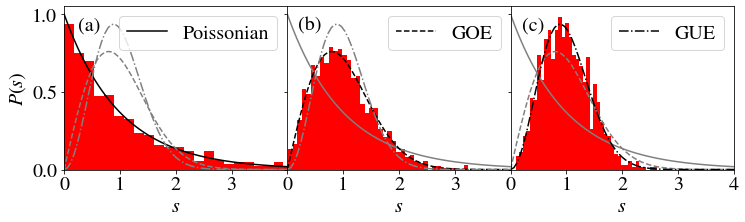

In [66]:
s=np.linspace(0, 6, 100)
fig, (ax1, ax2, ax3)=plt.subplots(1, 3, sharey=True, figsize=[12, 3])
ax1.plot(s, np.exp(-s), color='black', label="Poissonian")
ax1.plot(s, np.pi*s*0.5*np.exp(-np.pi*s**2/4), color='gray', ls='--')
ax1.plot(s, 32*s**2/np.pi**2*np.exp(-4*s**2/np.pi), color='gray', ls='-.')
ax1.hist(np.diff(unf_E_Poi),bins=40, density='True', color='red')
ax2.plot(s, np.exp(-s), color='gray')
ax2.plot(s, np.pi*s*0.5*np.exp(-np.pi*s**2/4), color='black', ls='--', label="GOE")
ax2.plot(s, 32*s**2/np.pi**2*np.exp(-4*s**2/np.pi), color='gray', ls='-.')
ax2.hist(np.diff(unf_E_GOE),bins=40, density='True', color='red')
ax3.plot(s, np.exp(-s), color='gray')
ax3.plot(s, np.pi*s*0.5*np.exp(-np.pi*s**2/4), color='gray', ls='--')
ax3.plot(s, 32*s**2/np.pi**2*np.exp(-4*s**2/np.pi), color='black', ls='-.', label="GUE")
ax3.hist(np.diff(unf_E_GUE),bins=40, density='True', color='red')
plt.subplots_adjust(wspace=0)
#plt.hist(np.diff(E), bins="auto", density='True')
#print(np.average(np.diff(unf_E)))
ax1.set_xlim(0,4)
ax2.set_xlim(0,4)
ax3.set_xlim(0,4)
ax1.set_xticks([0, 1,2, 3])
ax2.set_xticks([0, 1,2, 3])
ax3.set_xticks([0, 1,2, 3, 4])
ax1.set_xlabel("$s$")
ax2.set_xlabel("$s$")
ax3.set_xlabel("$s$")
ax1.set_ylabel("$P(s)$")
ax1.text(0.25, 0.9, "(a)")
ax2.text(0.2, 0.9, "(b)")
ax3.text(0.2, 0.9, "(c)")
ax1.legend(labelspacing=0)
ax2.legend(labelspacing=0)
ax3.legend(labelspacing=0)
plt.show()